In [ ]:
!pip install matplotlib pandas pillow numpy tqdm

In [ ]:
import json
from pathlib import Path
import glob
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

%matplotlib inline

repo_root = Path.cwd().parent
print("Repo root:", repo_root)

sample_outputs = repo_root / "sample_outputs"

report_path = sample_outputs / "milestone3_report.json"
clip_metrics_path = sample_outputs / "milestone3_clip_metrics.json"
encoder_metrics_path = sample_outputs / "milestone3_text_encoder.json"

print("FID/IS report:      ", report_path)
print("CLIP metrics:       ", clip_metrics_path)
print("Text encoder metrics:", encoder_metrics_path)

print("Exists? ",
      report_path.exists(),
      clip_metrics_path.exists(),
      encoder_metrics_path.exists())


Repo root: /home/padmanabhan.h/projects/text2img
FID/IS report:       /home/padmanabhan.h/projects/text2img/sample_outputs/milestone3_report.json
CLIP metrics:        /home/padmanabhan.h/projects/text2img/sample_outputs/milestone3_clip_metrics.json
Text encoder metrics: /home/padmanabhan.h/projects/text2img/sample_outputs/milestone3_text_encoder.json
Exists?  True True True


In [3]:
with open(report_path, "r") as f:
    report = json.load(f)

with open(clip_metrics_path, "r") as f:
    clip_metrics = json.load(f)

with open(encoder_metrics_path, "r") as f:
    encoder_metrics = json.load(f)

report, clip_metrics, encoder_metrics


({'config': {'n_samples': 1000,
   'val_csv': '../data/manifests/coco_train1k.csv'},
  'modelA': {'name': 'Milestone 1 baseline',
   'gen_dir': '../sample_outputs/milestone1_output',
   'FID': 72.3225,
   'IS_mean': 22.8508,
   'IS_std': 1.6321},
  'modelB': {'name': 'Milestone 2 improved',
   'gen_dir': '../sample_outputs/milestone2_output',
   'FID': 73.7589,
   'IS_mean': 23.322,
   'IS_std': 1.8462},
  'modelC': {'name': 'Attention-finetuned, 4k steps',
   'gen_dir': '../sample_outputs/modelC_finetuned_4k',
   'FID': 76.4798,
   'IS_mean': 22.8465,
   'IS_std': 2.5522},
  'timestamp': '2025-12-05 02:45:35.110983'},
 {'val_csv': '/home/padmanabhan.h/projects/text2img/data/manifests/coco_train1k.csv',
  'max_n_captions': 1000,
  'diversity_max_n': 200,
  'models': {'A': {'clip_similarity_mean': 0.31186483985185626,
    'clip_similarity_std': 0.0295633365821859,
    'clip_diversity_mean_1_minus_cos': 0.4529845416545868},
   'B': {'clip_similarity_mean': 0.3043605190515518,
    'clip_s

In [4]:
rows = []

for key, nice_name in [
    ("modelA", "Model A (baseline)"),
    ("modelB", "Model B (improved sampling)"),
    ("modelC", "Model C (attn finetuned 4k)"),
]:
    if key not in report:
        print(f"Warning: {key} missing in milestone3_report.json")
        continue
    rows.append({
        "Model_key": key,
        "Model": nice_name,
        "FID": report[key]["FID"],
        "IS_mean": report[key]["IS_mean"],
        "IS_std": report[key]["IS_std"],
    })

df_fid_is = pd.DataFrame(rows)
df_fid_is


,Model_key,Model,FID,IS_mean,IS_std
0,modelA,Model A (baseline),72.3225,22.8508,1.6321
1,modelB,Model B (improved sampling),73.7589,23.3220,1.8462
2,modelC,Model C (attn finetuned 4k),76.4798,22.8465,2.5522


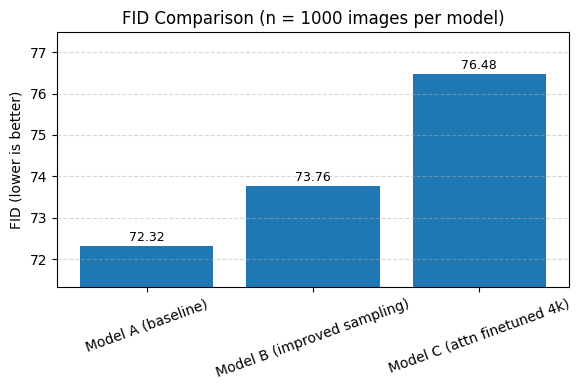

In [5]:
plt.figure(figsize=(6, 4))
x = df_fid_is["Model"]
y = df_fid_is["FID"].values

bars = plt.bar(x, y)
plt.title("FID Comparison (n = 1000 images per model)")
plt.ylabel("FID (lower is better)")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.xticks(rotation=20)

margin = 1.0
plt.ylim(y.min() - margin, y.max() + margin)

for bar, val in zip(bars, y):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        val + 0.05,
        f"{val:.2f}",
        ha="center",
        va="bottom",
        fontsize=9,
    )

plt.tight_layout()
plt.show()


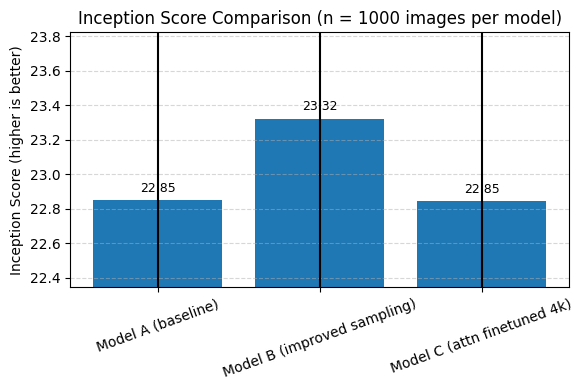

In [6]:
plt.figure(figsize=(6, 4))
x = df_fid_is["Model"]
means = df_fid_is["IS_mean"].values
stds = df_fid_is["IS_std"].values

bars = plt.bar(x, means, yerr=stds, capsize=6)
plt.title("Inception Score Comparison (n = 1000 images per model)")
plt.ylabel("Inception Score (higher is better)")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.xticks(rotation=20)

margin = 0.5
plt.ylim(means.min() - margin, means.max() + margin)

for bar, val in zip(bars, means):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        val + 0.03,
        f"{val:.2f}",
        ha="center",
        va="bottom",
        fontsize=9,
    )

plt.tight_layout()
plt.show()


In [7]:
clip_models = clip_metrics["models"]

rows = []
name_map = {
    "A": "Model A (baseline)",
    "B": "Model B (improved sampling)",
    "C": "Model C (attn finetuned 4k)",
}

for key, vals in clip_models.items():
    rows.append({
        "Model_short": key,
        "Model": name_map.get(key, key),
        "CLIP_similarity_mean": vals["clip_similarity_mean"],
        "CLIP_similarity_std": vals["clip_similarity_std"],
        "CLIP_diversity": vals["clip_diversity_mean_1_minus_cos"],
    })

df_clip = pd.DataFrame(rows)
df_clip


,Model_short,Model,CLIP_similarity_mean,CLIP_similarity_std,CLIP_diversity
0,A,Model A (baseline),0.311865,0.029563,0.452985
1,B,Model B (improved sampling),0.304361,0.029379,0.461449
2,C,Model C (attn finetuned 4k),0.308242,0.032037,0.490633


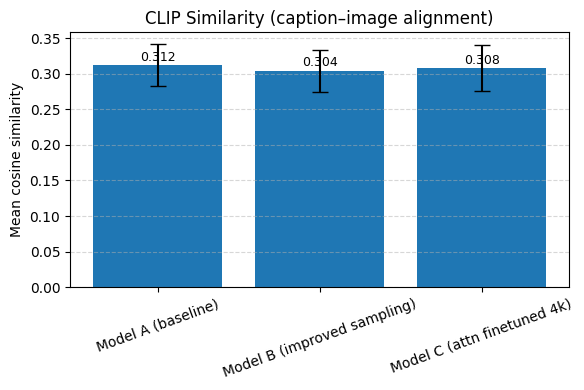

In [8]:
plt.figure(figsize=(6, 4))
x = df_clip["Model"]
y = df_clip["CLIP_similarity_mean"].values
yerr = df_clip["CLIP_similarity_std"].values

bars = plt.bar(x, y, yerr=yerr, capsize=6)
plt.title("CLIP Similarity (caption–image alignment)")
plt.ylabel("Mean cosine similarity")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.xticks(rotation=20)

for bar, val in zip(bars, y):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        val + 0.002,
        f"{val:.3f}",
        ha="center",
        va="bottom",
        fontsize=9,
    )

plt.tight_layout()
plt.show()


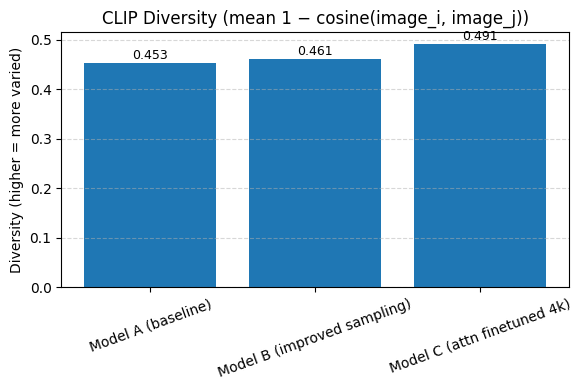

In [9]:
plt.figure(figsize=(6, 4))
x = df_clip["Model"]
y = df_clip["CLIP_diversity"].values

bars = plt.bar(x, y)
plt.title("CLIP Diversity (mean 1 − cosine(image_i, image_j))")
plt.ylabel("Diversity (higher = more varied)")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.xticks(rotation=20)

for bar, val in zip(bars, y):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        val + 0.002,
        f"{val:.3f}",
        ha="center",
        va="bottom",
        fontsize=9,
    )

plt.tight_layout()
plt.show()


In [ ]:
enc = encoder_metrics["metrics"]

rows = []
name_map = {
    "A": "Model A (baseline)",
    "B": "Model B (improved sampling)",
    "C": "Model C (attn finetuned 4k)",
}

for encoder_name, models in enc.items():
    for model_key, vals in models.items():
        rows.append({
            "Encoder": encoder_name,          
            "Model_short": model_key,         
            "Model": name_map.get(model_key, model_key),
            "mean": vals["mean"],
            "std": vals["std"],
        })

df_enc = pd.DataFrame(rows)
df_enc


,Encoder,Model_short,Model,mean,std
0,clip_vit_b32,A,Model A (baseline),0.311043,0.028405
1,clip_vit_b32,B,Model B (improved sampling),0.302828,0.030024
2,clip_vit_b32,C,Model C (attn finetuned 4k),0.307582,0.032344
3,clip_vit_l14,A,Model A (baseline),0.264646,0.030933
4,clip_vit_l14,B,Model B (improved sampling),0.256543,0.032707
5,clip_vit_l14,C,Model C (attn finetuned 4k),0.261137,0.034818


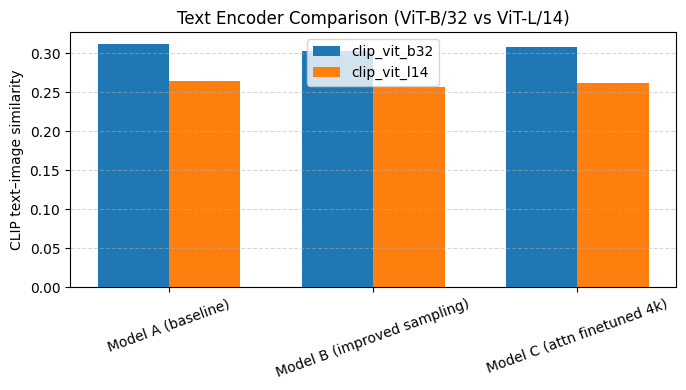

In [11]:
plt.figure(figsize=(7, 4))

encoders = df_enc["Encoder"].unique()
models = ["Model A (baseline)", "Model B (improved sampling)", "Model C (attn finetuned 4k)"]

x = np.arange(len(models))
width = 0.35

for i, enc_name in enumerate(encoders):
    sub = df_enc[df_enc["Encoder"] == enc_name].set_index("Model").loc[models]
    offset = (i - (len(encoders) - 1) / 2) * width
    bars = plt.bar(x + offset, sub["mean"].values, width, label=enc_name)

plt.xticks(x, models, rotation=20)
plt.ylabel("CLIP text–image similarity")
plt.title("Text Encoder Comparison (ViT-B/32 vs ViT-L/14)")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


In [12]:
summary_rows = []

for _, row in df_fid_is.iterrows():
    m = row["Model"]
    summary_rows.append({
        "Model": m,
        "FID": row["FID"],
        "IS_mean": row["IS_mean"],
        "CLIP_similarity": float(df_clip.set_index("Model").loc[m]["CLIP_similarity_mean"]),
        "CLIP_diversity": float(df_clip.set_index("Model").loc[m]["CLIP_diversity"]),
    })

df_summary = pd.DataFrame(summary_rows)
df_summary


,Model,FID,IS_mean,CLIP_similarity,CLIP_diversity
0,Model A (baseline),72.3225,22.8508,0.311865,0.452985
1,Model B (improved sampling),73.7589,23.3220,0.304361,0.461449
2,Model C (attn finetuned 4k),76.4798,22.8465,0.308242,0.490633


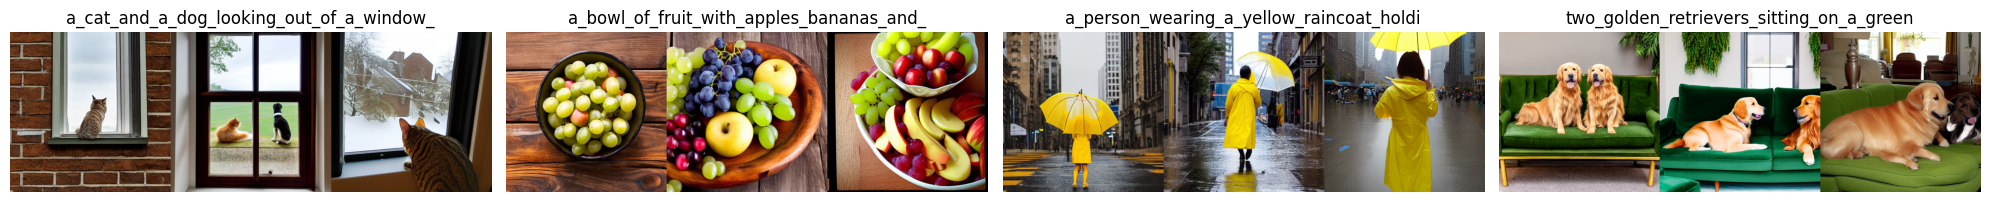

In [13]:
def show_compositional_grids(grid_dir, max_grids=4):
    grid_dir = Path(grid_dir)
    paths = sorted(grid_dir.glob("*ABC_grid.png"))
    if not paths:
        print(f"No *_ABC_grid.png found in {grid_dir}")
        return
    
    random.seed(42)
    paths = random.sample(paths, min(max_grids, len(paths)))
    
    n = len(paths)
    plt.figure(figsize=(5 * n, 5))
    for i, p in enumerate(paths):
        img = Image.open(p).convert("RGB")
        plt.subplot(1, n, i + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(p.stem[:40])
    plt.tight_layout()
    plt.show()

compositional_dir = sample_outputs / "compositional_benchmark"
show_compositional_grids(compositional_dir, max_grids=4)


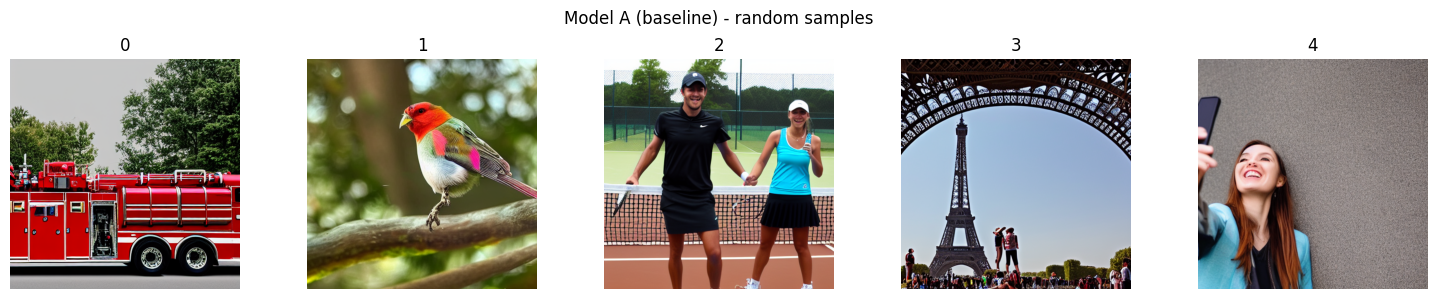

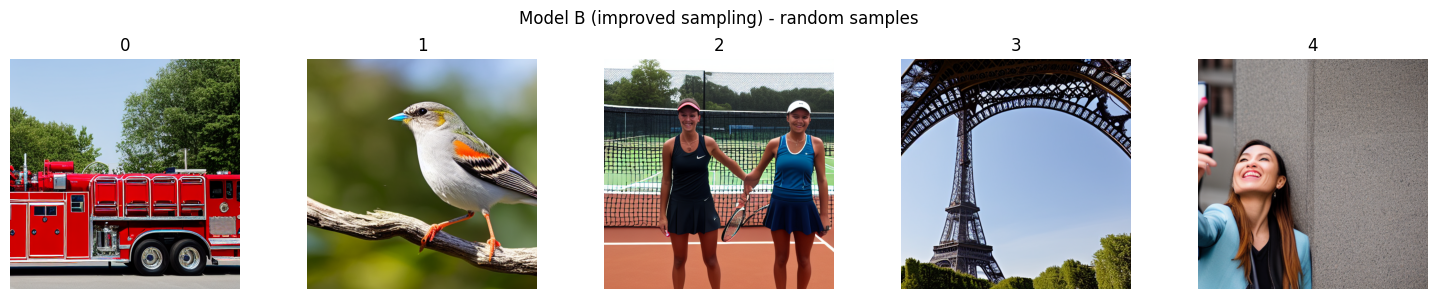

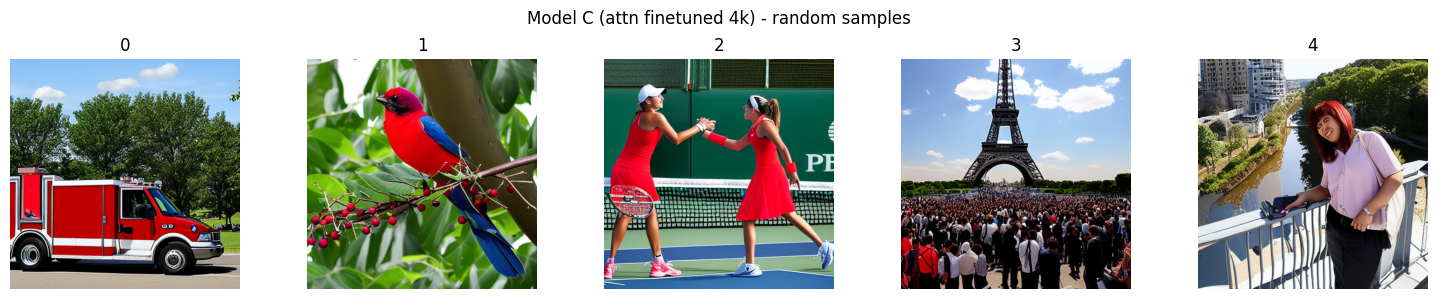

In [14]:
def show_samples(img_dir, title, max_images=5):
    img_paths = sorted(glob.glob(str(img_dir / "*.png")))
    if not img_paths:
        print(f"No PNG images found in {img_dir}")
        return
    
    img_paths = img_paths[:max_images]
    n = len(img_paths)
    plt.figure(figsize=(3 * n, 3))
    
    for i, path in enumerate(img_paths):
        img = Image.open(path).convert("RGB")
        plt.subplot(1, n, i + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"{i}")
        
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

model_a_dir = sample_outputs / "milestone1_output"
model_b_dir = sample_outputs / "milestone2_output"
model_c_dir = sample_outputs / "modelC_finetuned_4k"

show_samples(model_a_dir, "Model A (baseline) - random samples")
show_samples(model_b_dir, "Model B (improved sampling) - random samples")
show_samples(model_c_dir, "Model C (attn finetuned 4k) - random samples")
